In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Plot inline
% matplotlib inline
style='../mpl_styles/spykes.mplstyle'
plt.style.use(style)

In [2]:
from neuropop import NeuroPop

### Create a NeuroPop object

In [3]:
n_neurons = 10
pop = NeuroPop(n_neurons, tunemodel='glm', fit_k=True, n_repeats=1, 
               learning_rate=2e-1, random_state=1, convergence_threshold=1e-6)

### Simulate a population of neurons

In [4]:
# Simulate a population of neurons
n_samples = 500
x, Y, mu, k0, k, g, b = pop.simulate(pop.tunemodel, n_samples=500, noise_mu=0.0, noise_sigma=1.0)

### Fit the tuning curves with gradient descent

In [5]:
pop.fit(x, Y)

### Predict the population activity with the fit tuning curves

In [6]:
Yhat = pop.predict(x)

### Plot the simulated and fit tuning curves

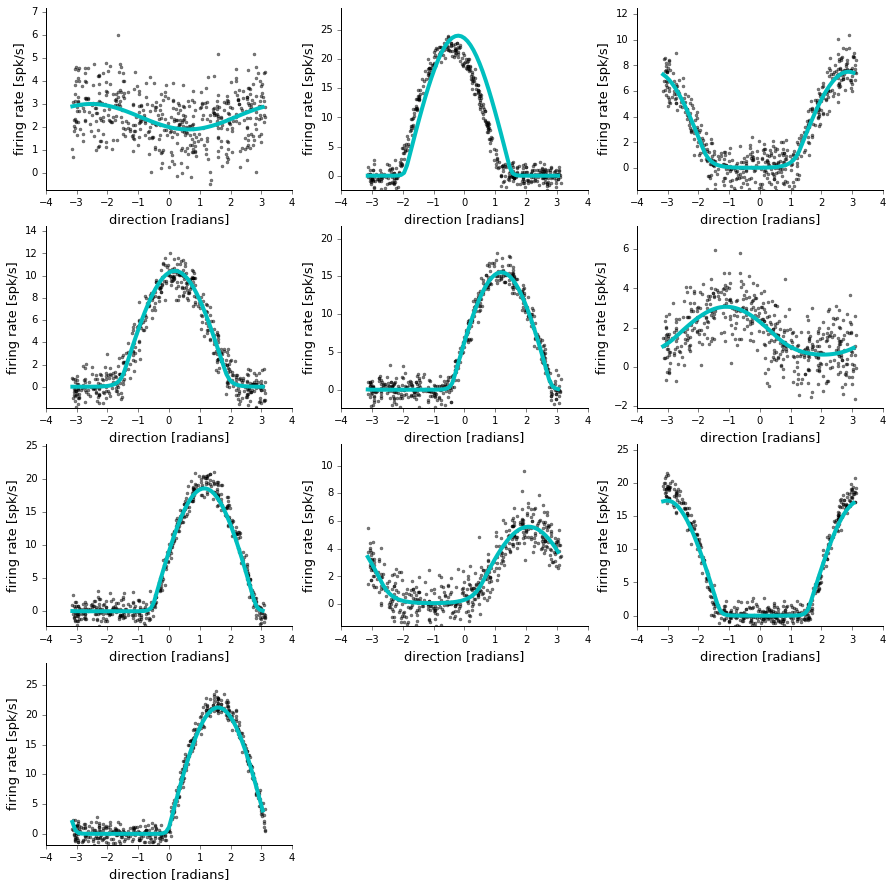

In [7]:
plt.figure(figsize=[15,15])

for neuron in range(pop.n_neurons):
    plt.subplot(4,3,neuron+1)
    pop.display(x, Y[:, neuron], neuron=neuron, 
                ylim=[0.8*np.min(Y[:, neuron]), 1.2*np.max(Y[:, neuron])])

plt.show()

### Decode feature from the population activity

In [8]:
xhat = pop.decode(Y)

### Visualize ground truth vs. decoded estimates

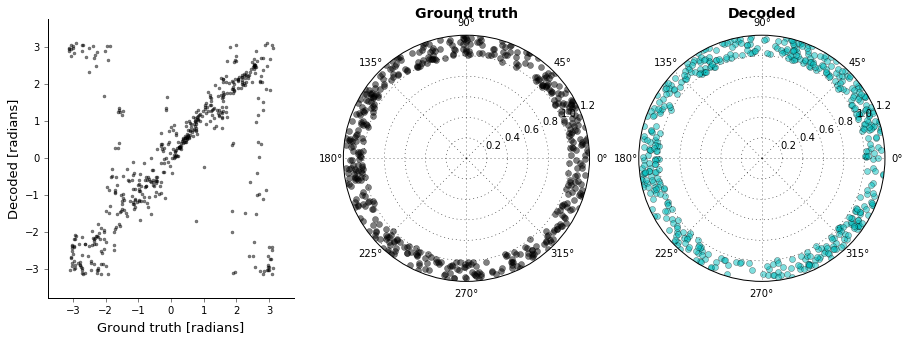

In [9]:
plt.figure(figsize=[15,5])

plt.subplot(131)
plt.plot(x, xhat, 'k.', alpha=0.5)
plt.xlim([-1.2*np.pi, 1.2*np.pi])
plt.ylim([-1.2*np.pi, 1.2*np.pi])
plt.xlabel('Ground truth [radians]')
plt.ylabel('Decoded [radians]')
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

jitter = 0.2*np.random.rand(x.shape[0])
plt.subplot(132, polar=True)
plt.plot(x, np.ones(x.shape[0]) + jitter, 'ko', alpha=0.5)
plt.title('Ground truth')

plt.subplot(133, polar=True)
plt.plot(xhat, np.ones(xhat.shape[0]) + jitter, 'co', alpha=0.5)
plt.title('Decoded')
plt.show()

### Quantify decoding performance

In [10]:
from scipy import stats
def circ_corr(alpha1, alpha2):
    alpha1_bar = stats.circmean(alpha1)
    alpha2_bar = stats.circmean(alpha2)
    num = np.sum(np.sin(alpha1 - alpha1_bar) * np.sin(alpha2 - alpha2_bar));
    den = np.sqrt(np.sum(np.sin(alpha1 - alpha1_bar) ** 2) * np.sum(np.sin(alpha2 - alpha2_bar) ** 2));
    rho = num / den
    return rho


In [11]:
circ_corr(x, xhat)

0.61521062131860105

In [12]:
print x[:5]
print xhat[:5]

[-2.49860647 -0.54000215  1.22145221 -0.53922755 -2.82772581]
[ 2.97152621 -0.57371526  1.27780975 -0.32960249 -2.32025366]
